<a target="_blank" href="https://colab.research.google.com/github/avakanski/Fall-2022-Python-Programming-for-Data-Science/blob/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2021%20-%20Model%20Selection%2C%20Hyperparameter%20Tuning/Lecture%2021%20-%20Model%20Selection%2C%20Hyperparameter%20Tuning.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<a name='section0'></a>
# Lecture 22 Diffusion Models for Text-2-Image Generation

- [22.1 Generative Text-2-Image Models](#section1)
- [22.2 High-Level API for Stable Diffusion with Keras](#section2)
- [22.3 Denoising Diffusion Probabilistic Models](#section3)
    - [22.3.1 Forward Diffusion Process](#section3-1)
    - [22.3.2 Reverse Diffusion Process](#section3-2)
- [22.4 Latent Diffusion Models](#section4)    
- [References](#section10)






<a name='section1'></a>

# 22.1 Generative Text-2-Image Models

Generative models learn to generate new data instances

The family of GAN models (StyleGAN, CycleGAN, BigGAN) were the most important generative models in recent years.

In the last 2 years, several text-to-image generative models with improved capabiolity emerged, including [DALL-E 2](https://openai.com/dall-e-2/) by OpenAI, [Stable Diffusion](https://github.com/CompVis/latent-diffusion) by Stability.AI, [ImageGen](https://imagen.research.google/) by Google Brain.

Text-to-image generative models rely on learned representations by deep NNs that are trained on pairs of images and image captions. The models are afterward trained to generate new images given a text prompt.

These models employ **Denoising Diffusion Probabilistic Models** (DDPMs), or they are also simply referred to as Diffusion Models. 
Diffusion Models convert Gaussian noise into images from a learned data distribution by an iterative denoising process. 

<a name='section2'></a>

# 22.2 High-Level API for Stable Diffusion with Keras

To run the model we need to first install `keras_cv` package. Aftreward, we can just load a Stable Diffustion model and give a prompt to generate images.

In [ ]:
!pip install keras_cv --upgrade --quiet

In [ ]:
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
# Instantiate a Stable Diffusion model
model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


25/25 [==============================] - 19s 314ms/step


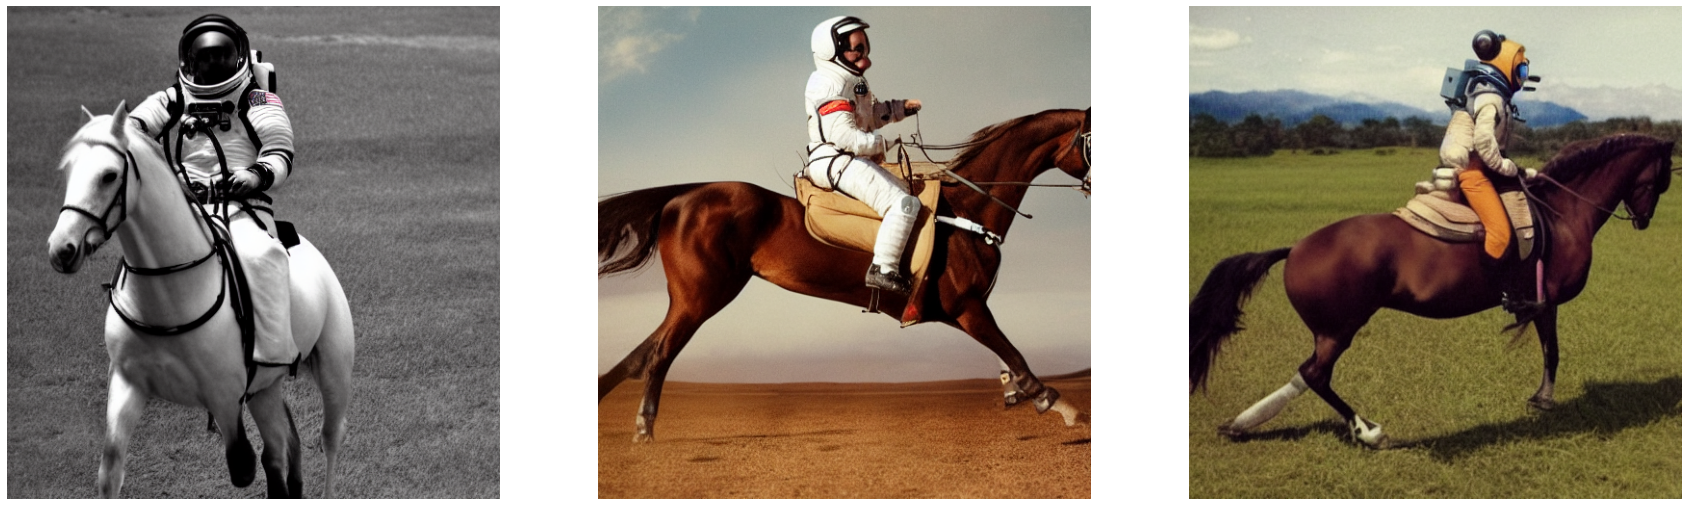

In [ ]:
# generate images (it takes less than 1 minute with Google Colab Pro)
images = model.text_to_image("photograph of an astronaut riding a horse", batch_size=3)

# plot the images
plt.figure(figsize=(30, 10))
for i in range(len(images)):
    ax = plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i])
    plt.axis("off")

25/25 [==============================] - 8s 314ms/step


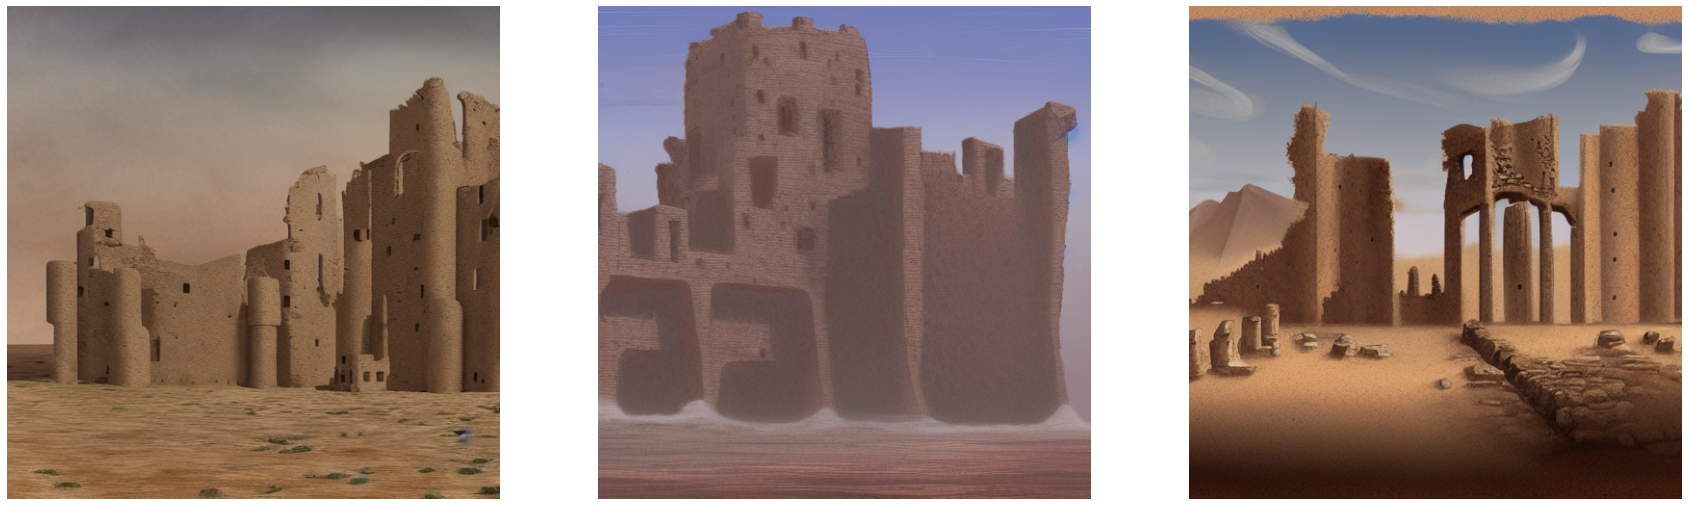

In [ ]:
# generate images (it takes abut 1 minute per image with Google Colab Pro)
images = model.text_to_image("ruins of an ancient castle in a desert, concept art", batch_size=3)

# plot the images
plt.figure(figsize=(30, 10))
for i in range(len(images)):
    ax = plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i])
    plt.axis("off")

25/25 [==============================] - 8s 313ms/step


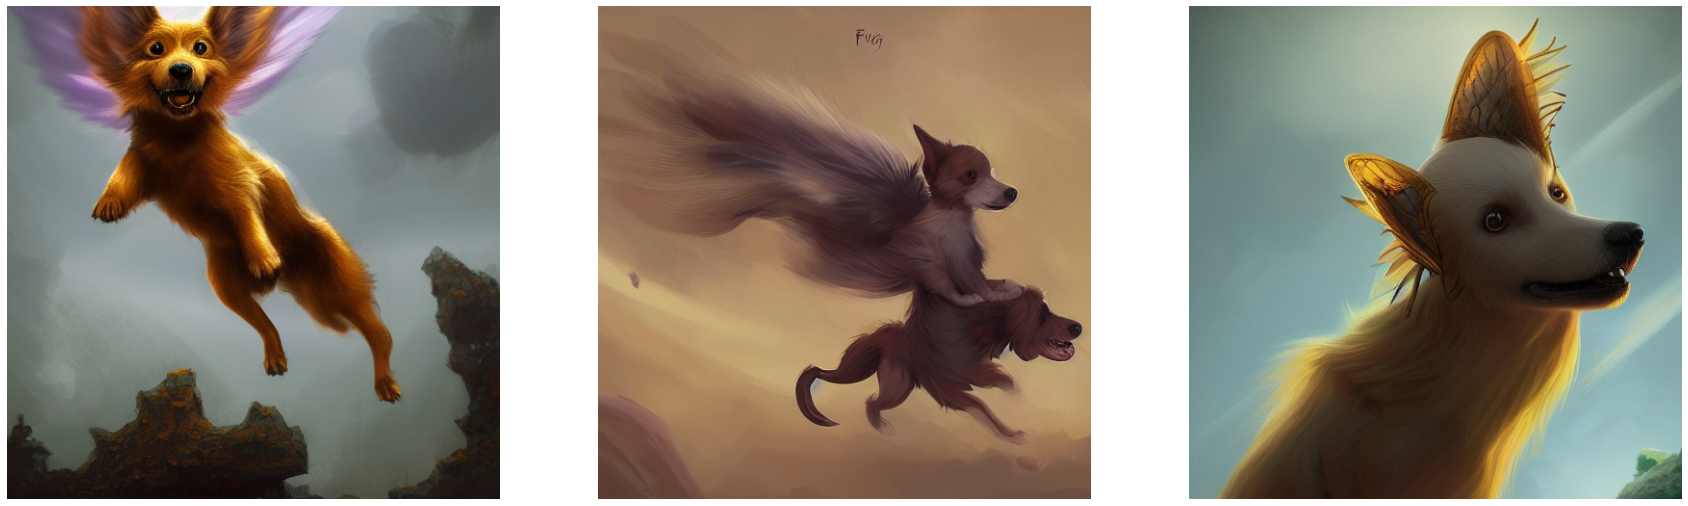

In [ ]:
# generate images
images = model.text_to_image("a cute magical flying dog, fantasy art, golden color, high quality, highly detailed, elegant, sharp focus,"
    "concept art, character concepts, digital painting, mystery, adventure",  batch_size=3)

# plot the images
plt.figure(figsize=(30, 10))
for i in range(len(images)):
    ax = plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i])
    plt.axis("off")

<a name='section3'></a>

# 22.3 Denoising Diffusion Probabilistic Models

Denising diffusion probabilistic process consists of two phases:
1. Forward diffusion process, in which Gaussian noise is gradually added to an image, until the image becomes pure noise.
2. Reverse diffusion process, in which the images with Gaussian noise are gradually denoised, until all noise is removed. 

<a name='section3-1'></a>

## 22.3.1 Forward Diffusion Process

For an initial image denoted $\textbf{x}_0$ that is sampled from the data distribution $q(x)$, the forward diffusion process adds noise over $T$ consecutive steps. At each step, the added Gaussian noise has variance $\beta_{t}$. I.e., the sample $\textbf{x}_{t}$ that correspond to the step $t$ of the forward process, is obtained by adding Gaussian noise to the sample $\textbf{x}_{t-1}$ from step $t−1$. Therefore the conditional probability density of the forward diffusion process $q(\textbf{x}_t |\textbf{x}_{t-1})$ can be written as:

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{1-\beta_{t}}\mathbf{x}_{t-1},\beta_{t}\mathbf{I})
$$

The above notation means that $\textbf{x}_t$ has Gaussian distribution, with a mean ${1-\beta_{t}}\mathbf{x}_{t-1}$ and variance $\beta_{t}\mathbf{I}$.

[image frward_diffusion.png]

Such process where the probability of an event at any given state is dependent only on the immediately preceeding state is called *Markov Chain* or *Markov Process*.

The mean and variance of the samples depend on a parameter $\beta_{t}$, which is a hyperparameter that defines the schedule of adding the Gaussian noise. The value of $\beta_{t}$ can either be constant for all steps, or it can be gradually changed (e.g., by using a sigmoid, tanh, linear function, etc).

Substituting $\alpha_{t}=1-\beta_{t}$, and $\bar{\alpha}_{t} = \prod_{s=1}^{t} \alpha_{s}$, the distribution can also be rewritten as:

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{0}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{t-1},(1-\bar{\alpha}_{t})\mathbf{I})
$$

This substitution allows to draw samples at any timestep without going through the intermediate steps. Hence, the variable $\textbf{x}_{t}$ of the forward diffusion can be written in terms of the intial image $x_0$ and the random Gaussian noise $\epsilon \sim \mathcal{N}(0,1)$ as:

$$
x_t(x_0,\epsilon) = \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1-\bar{\alpha_{t}}}\epsilon          
$$

Note that the forward diffusion process does not inolve learning. It is a sinmple process that just applies noise to an image. 

### Example of Forward Diffusion

An example of performing forward diffusion is shown below, based on the repository in [https://github.com/azad-academy/denoising-diffusion-model](https://github.com/azad-academy/denoising-diffusion-model).

The code in the next cells applies Gaussian noise to an image of the letter S over 100 steps. In the figure, the images for every 10th step of the noise-adding process are shown. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Code from: https://github.com/azad-academy/denoising-diffusion-model

cd "drive/MyDrive/Data_Science_Course/Lecture_22-Diffusion_Models/helper_functions/"

/content/drive/MyDrive/Data_Science_Course/Lecture_22-Diffusion_Models/helper_functions


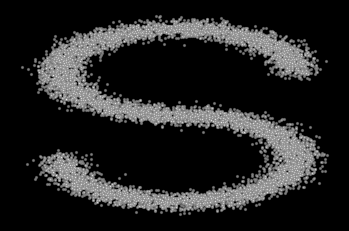

In [ ]:
import numpy as np
from sklearn.datasets import make_s_curve
import matplotlib.pyplot as plt
from helper_plot import hdr_plot_style
import torch
from utils import * 

# create S curve
s_curve, _= make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]]/10.0

data = s_curve.T

# plot the S curve
hdr_plot_style()
plt.scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5)
plt.axis('off')

dataset = torch.Tensor(data.T).float()

In [ ]:
num_steps = 100

# apply a sigmoid schedule for the beta parameter
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

# substitute alphas
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [ ]:
# draw a sample at step t, given an initial image x_0 
def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

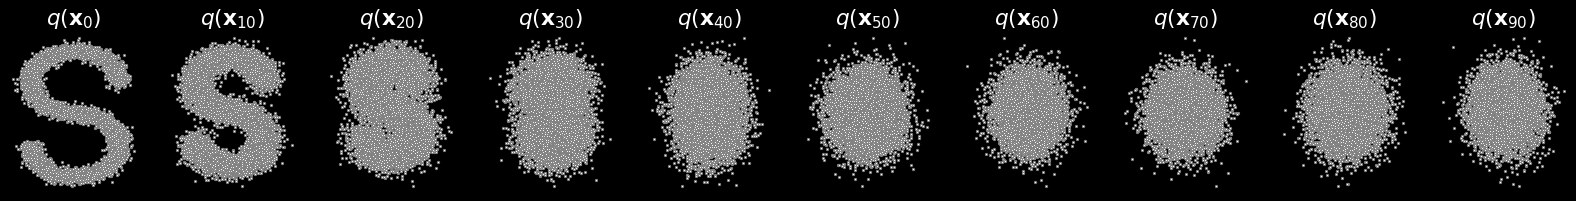

In [ ]:
# plot the samples for steps 0, 10, 20, ..., 90
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    q_i = q_x(dataset, torch.tensor([i * 10]))
    axs[i].scatter(q_i[:, 0], q_i[:, 1], color='white', edgecolor='gray', s=5)
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

As mentioned above, we can obtain a sample at any desired step in the forward diffusion process, by applying the level of Gaussian noise directly to the initial image. The cell below shows the image at step 15. 

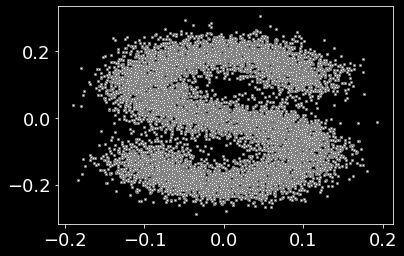

In [ ]:
# image in the 15th step
q_15 = q_x(dataset, torch.tensor([15]))
plt.scatter(q_15[:, 0], q_15[:, 1], color='white', edgecolor='gray', s=5);

<a name='section3-2'></a>

## 22.3.2 Reverse Diffusion Process

The goal of the reverse diffusion process is to denoise the images from the forward diffusion process, i.e., start with a noise image and obtain a clean image. Accurately calculating the reverse process $q(\textbf{x}_{t-1}|\textbf{x}_{t})$ is intractable, and text-to-image models apply a deep neural network to approximate the probability density function $q(\textbf{x}_{t-1}|\textbf{x}_{t})$ with a parameterized model $p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_{t})$ where $\theta$ denotes the parameters of the deep neural network model that are learned. I.e., the model will take as input a noisy image at step $\textbf{x}_{t-1}$ and predict the mean and the variance of a denoised image $\textbf{x}_{t}$. 





### Example of Reverse Diffusion

The reverse diffusion process for the image S from the above example is presented below. The model is trained for 1,000 iterations, and the denoising images at steps 100, 200, 300, ..., 1000 are shown in the figure below for each hudreds of iterations. In the last row of images, we can see that the model begins with a noisy image on the left and it ends with a denoised image on the right. 

In [ ]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

The U-Net model is imported in the next cell, and the model is trained for 1,000 iterations.

In [ ]:
from model import ConditionalModel
from ema import EMA
import torch.optim as optim

model = ConditionalModel(num_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 128

# training
for t in range(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss
        loss = noise_estimation_loss(model, batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape,num_steps,alphas,betas,one_minus_alphas_bar_sqrt)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='gray', s=5);
            axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

Output hidden; open in https://colab.research.google.com to view.

The next cell is used to create a gif image of the denoising process. The image is shown below. 

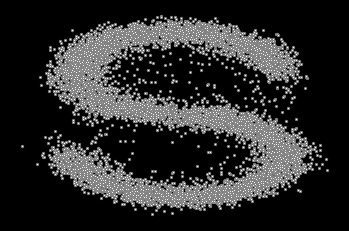

In [ ]:
# Generating the reverse diffusion sequence
import io
from PIL import Image

reverse = []
for i in range(100):  
    plt.clf()
    cur_x = x_seq[i].detach()
    plt.scatter(cur_x[:, 0], cur_x[:, 1], color='white', edgecolor='gray', s=5)
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    reverse.append(img)

### U-Net Model for Reverse Diffusion

A U-Net model is used for the reverse diffusion phase. ***U-Net*** is a popular model for image segmentation, and it has an architecture that looks like the letter U. It includes an encoder sub-network that extracts lower-dimensional representations, and a decoder sub-network that reconstructs the representations to full size images. When U-Net is used for image segmentation, the inputs are images, and the outputs are segmentation masks that segment the objects in the input images. 

<a name='section4'></a>

# 22.4 Latent Diffusion Models

Latent 

Stable diffusion: Latent diffusion models
Latent diffusion models are based on a rather simple idea: instead of applying the diffusion process directly on a high-dimensional input, we project the input into a smaller latent space and apply the diffusion there.

In more detail, Rombach et al. proposed to use an encoder network to encode the input into a latent representation i.e. \mathbf{z}_t = g(\mathbf{x}_t)z 
t
​
 =g(x 
t
​
 ). The intuition behind this decision is to lower the computational demands of training diffusion models by processing the input in a lower dimensional space. Afterward, a standard diffusion model (U-Net) is applied to generate new data, which are upsampled by a decoder network.

If the loss for a typical diffusion model (DM) is formulated as:

L _{DM} = \mathbb{E}_{\mathbf{x}, t, \boldsymbol{\epsilon}} \Big[\| \boldsymbol{\epsilon}- \boldsymbol{\epsilon}_{\theta}( \mathbf{x}_t, t ) ||^2 \Big]
L 
DM
​
 =E 
x,t,ϵ
​
 [∥ϵ−ϵ 
θ
​
 (x 
t
​
 ,t)∣∣ 
2
 ]
then given an encoder \mathcal{E}E and a latent representation zz, the loss for a latent diffusion model (LDM) is:

In [ ]:
reverse[0].save("diffusion_S.gif", format='GIF', append_images=reverse, save_all=True, duration=100, loop=0)

<a name='section10'></a>

# References

1. High-performance image generation using Stable Diffusion in KerasCV, available at [https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/).
2. Diffusion Models Made Easy, J. Rafid Siddiqui, available at [https://towardsdatascience.com/diffusion-models-made-easy-8414298ce4da](https://towardsdatascience.com/diffusion-models-made-easy-8414298ce4da).
3. How Diffusion Models Work: The Math From Scratch, available at [https://theaisummer.com/diffusion-models/](https://theaisummer.com/diffusion-models/).

[BACK TO TOP](#section0)